# Steps and Methodology:
## Data Generation (Synthetic Fleet Data):

1. Generate synthetic fleet data mimicking Tesla’s fleet, including attributes such as car ID, GPS coordinates, speed, lane changes, braking events, and sensor status.
2. Simulate driving events such as collision alerts, autonomous interventions, or harsh braking.
3. Use Python to create a data generator and save the dataset to a storage system like PostgreSQL.

## Data Ingestion with PySpark:

1. Create a PySpark pipeline that reads the synthetic fleet data from PostgreSQL.
2. Perform initial ETL (Extract, Transform, Load) operations to filter unnecessary data and clean up the dataset for further analysis.
3. Set up batch processing using Spark DataFrames for periodic data ingestion.

## Driving Event Detection and Metric Calculation:

1. Develop custom Python scripts or PySpark UDFs (User Defined Functions) to identify driving events like abrupt stops, overspeeding, and route deviations.
2. Calculate key performance metrics such as average speed per route, reaction time to obstacles, and frequency of manual overrides.
3. Store the metrics back into PostgreSQL or a distributed file system (HDFS).

## Real-Time Visualization with Grafana:

1. Connect Grafana to PostgreSQL (or PySpark via streaming) to visualize metrics like car speed trends, system alerts, and driving event heatmaps.
2. Set up real-time dashboards that showcase self-driving performance data using Grafana’s built-in features or custom JavaScript widgets.
3. Display alerts in Grafana for scenarios like high-frequency braking events, vehicle slowdowns, or network delays in fleet data ingestion.

## Data Pipeline Monitoring and Alerts:

1. Implement a monitoring system that sends alerts when the PySpark jobs or Grafana metrics fail to update within a specific time window.
2. Set up Spark logs to detect anomalies in the fleet data pipeline, such as excessive data lag or high processing time.
3. Optional: Use Spark Streaming for real-time data ingestion, allowing faster response to critical driving events.

In [1]:
#!pip install psycopg2-binary faker

1. Psycopg2 for connecting to PostgreSQL
2. Faker to generate random vehicle IDs and timestamps

## Define the Key Attributes:

1. vehicle_id: A unique identifier for each vehicle.
2. timestamp: Time at which the data is recorded.
3. latitude and longitude: GPS coordinates.
4. speed: Vehicle’s speed at that moment.
5. event_type: Driving events like normal driving, braking, lane change, etc.
6. braking_event: Binary field (1 for braking, 0 for no braking).
7. collision_alert: Binary field (1 for collision alert, 0 for none).
8. lane_change: Binary field (1 for lane change, 0 for none).

## Generate Synthetic Data with Python

In [2]:
import random
import pandas as pd
from faker import Faker
import psycopg2
from datetime import datetime, timedelta

# Initialize Faker for random data
fake = Faker()

# Function to generate random GPS coordinates (latitude and longitude)
def generate_gps_coordinates():
    lat = random.uniform(-90, 90)
    lon = random.uniform(-180, 180)
    return lat, lon

# Function to generate synthetic fleet data
def generate_fleet_data(num_vehicles=100, num_records=1000):
    data = []

    for _ in range(num_records):
        vehicle_id = fake.license_plate()
        timestamp = fake.date_time_between(start_date='-1y', end_date='now')
        lat, lon = generate_gps_coordinates()
        speed = round(random.uniform(0, 120), 2)  # Speed between 0 and 120 km/h
        event_type = random.choice(['normal', 'braking', 'collision', 'lane_change'])
        braking_event = 1 if event_type == 'braking' else 0
        collision_alert = 1 if event_type == 'collision' else 0
        lane_change = 1 if event_type == 'lane_change' else 0

        # Append the record to the dataset
        data.append({
            'vehicle_id': vehicle_id,
            'timestamp': timestamp,
            'latitude': lat,
            'longitude': lon,
            'speed': speed,
            'event_type': event_type,
            'braking_event': braking_event,
            'collision_alert': collision_alert,
            'lane_change': lane_change
        })
    
    return pd.DataFrame(data)

# Generate a dataset with 1000 records
df_fleet = generate_fleet_data(num_records=1000)
df_fleet.head()

,vehicle_id,timestamp,latitude,longitude,speed,event_type,braking_event,collision_alert,lane_change
0,XW5 1761,2024-05-08 13:51:22.080656,15.269426,72.864261,0.51,lane_change,0,0,1
1,3L UZ783,2024-09-01 04:13:37.159166,3.287068,-142.708142,44.59,braking,1,0,0
2,QXF 825,2023-10-13 00:07:03.333589,2.153469,49.858755,7.22,normal,0,0,0
3,8M BY522,2024-02-13 13:20:16.163457,-41.980996,-1.055217,98.43,normal,0,0,0
4,QEJ-8831,2024-02-20 01:26:28.862284,34.071268,-116.817818,11.21,collision,0,1,0


## Save Data to PostgreSQL

In [3]:
def connect_to_postgres():
    try:
        # Connect to PostgreSQL database
        connection = psycopg2.connect(
            host="localhost",  # Or your PostgreSQL server
            port = "5433", # check this port
            database="fleet_db",  # Your database name
            user="postgres",  # Your PostgreSQL username
            password="1234"  # Your PostgreSQL password
        )
        return connection
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

In [4]:
connect_to_postgres

<function __main__.connect_to_postgres()>

In [5]:
def save_to_postgres(df, table_name='fleet_data'):
    # Connect to PostgreSQL
    connection = connect_to_postgres()
    
    if connection is not None:
        cursor = connection.cursor()
        # Create table if it doesn't exist
        cursor.execute(f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                vehicle_id VARCHAR(20),
                timestamp TIMESTAMP,
                latitude FLOAT,
                longitude FLOAT,
                speed FLOAT,
                event_type VARCHAR(20),
                braking_event INTEGER,
                collision_alert INTEGER,
                lane_change INTEGER
            );
        """)
        connection.commit()

        # Insert each row into the database
        for index, row in df.iterrows():
            cursor.execute(f"""
                INSERT INTO {table_name} (vehicle_id, timestamp, latitude, longitude, speed, event_type, braking_event, collision_alert, lane_change)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
            """, tuple(row))
        
        connection.commit()
        cursor.close()
        connection.close()
        print(f"Data saved to {table_name} successfully.")
    else:
        print("Failed to connect to the database.")


In [6]:
save_to_postgres(df_fleet)

Data saved to fleet_data successfully.


## Save the table in a Local directory

In [7]:
def export_table_to_csv(host, port, database, user, password, table_name, output_file):
    try:
        # Connect to PostgreSQL
        connection = psycopg2.connect(
            host=host,
            port=port,
            database=database,
            user=user,
            password=password
        )
        
        # Read data from PostgreSQL into a pandas DataFrame
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql_query(query, connection)
        
        # Save DataFrame to a CSV file
        df.to_csv(output_file, index=False)
        
        print(f"Data exported to {output_file} successfully.")
    
    except Exception as e:
        print(f"Error: {e}")
    
    finally:
        if connection:
            connection.close()

# Usage
export_table_to_csv(
    host="localhost",
    port = "5433",
    database="fleet_db",
    user="postgres",
    password="1234",
    table_name="fleet_data", #check the name carefully
    output_file="/Users/owner/Desktop/PySpark/fleet_data.csv"
)

Data exported to /Users/owner/Desktop/PySpark/fleet_data.csv successfully.


/var/folders/2c/4xnzffps6fsdxfczqpbvrcyr0000gn/T/ipykernel_3064/512699061.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


## Data Ingestion with PySpark:
1. Create a PySpark pipeline that reads the synthetic fleet data from PostgreSQL.

In [8]:
from pyspark.sql import SparkSession

In [17]:
# Configure Spark session and include the PostgreSQL JDBC driver MOST IMPORTANT OR POSTGRESQL WONT CONNECT
spark = SparkSession.builder.appName("FleetDataIngestion").config("spark.jars", "/Users/owner/Desktop/PySpark/postgresql-42.7.3.jar").getOrCreate()

In [10]:
# Path to your local CSV file
csv_file_path = "/Users/owner/Desktop/PySpark/fleet_data.csv"

# Read the CSV file into a DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Show the DataFrame
df.show()

+----------+--------------------+-------------------+-------------------+------+-----------+-------------+---------------+-----------+
|vehicle_id|           timestamp|           latitude|          longitude| speed| event_type|braking_event|collision_alert|lane_change|
+----------+--------------------+-------------------+-------------------+------+-----------+-------------+---------------+-----------+
|   QMG 723|2023-11-20 20:05:...|   75.7704680031548|  -175.319359378314| 63.78|lane_change|            0|              0|          1|
|  08-68326|2024-06-23 19:31:...|   79.1280017195574| -74.76058119030988| 16.58|     normal|            0|              0|          0|
|  UKW-4868|2024-05-29 23:37:...| 19.903744818951182|  -49.7772239218782| 61.25|lane_change|            0|              0|          1|
|  3D 3214M|2024-04-20 01:55:...|  70.36686216918838|-102.94566247662247|101.07|lane_change|            0|              0|          1|
|   8-48571|2024-03-13 16:20:...| 10.365462427972048|-1

2. Perform initial ETL (Extract, Transform, Load) operations to filter unnecessary data and clean up the dataset for further analysis.

In [11]:
# Data Processing


# Filter data where speed is greater than 50
filtered_df = df.filter(df.speed > 50)
filtered_df.show()

+----------+--------------------+-------------------+-------------------+------+-----------+-------------+---------------+-----------+
|vehicle_id|           timestamp|           latitude|          longitude| speed| event_type|braking_event|collision_alert|lane_change|
+----------+--------------------+-------------------+-------------------+------+-----------+-------------+---------------+-----------+
|   QMG 723|2023-11-20 20:05:...|   75.7704680031548|  -175.319359378314| 63.78|lane_change|            0|              0|          1|
|  UKW-4868|2024-05-29 23:37:...| 19.903744818951182|  -49.7772239218782| 61.25|lane_change|            0|              0|          1|
|  3D 3214M|2024-04-20 01:55:...|  70.36686216918838|-102.94566247662247|101.07|lane_change|            0|              0|          1|
|   8-48571|2024-03-13 16:20:...| 10.365462427972048|-147.17042644248468| 79.67|     normal|            0|              0|          0|
|  IE 09716|2024-08-12 00:55:...|  -46.0671276549347| -

In [12]:
# Group by event type and count occurrences
aggregated_df = df.groupBy("event_type").count()
aggregated_df.show()

+-----------+-----+
| event_type|count|
+-----------+-----+
|lane_change| 1260|
|    braking| 1264|
|  collision| 1216|
|     normal| 1260|
+-----------+-----+



In [13]:
# Initialize Spark session with JDBC JAR
#spark = SparkSession.builder \
#    .appName("FleetDataIngestion") \
#    .getOrCreate()

# Define PostgreSQL JDBC URL and properties
db_url = "jdbc:postgresql://localhost:5433/fleet_db"
db_properties = {
    "user": "postgres",
    "password": "1234",
    "driver": "org.postgresql.Driver"
}

# Write DataFrame to PostgreSQL
filtered_df.write.format('jdbc')\
                 .mode('overwrite')\
                 .option('url', db_url)\
                 .option('dbtable', 'filtered_fleet_data')\
                 .option('user', db_properties['user'])\
                 .option('password', db_properties['password'])\
                 .option('driver', db_properties['driver'])\
                 .save()

# Stop Spark session
spark.stop()

3. Set up batch processing using Spark DataFrames for periodic data ingestion.

In [18]:
# Load the filtered table from postgresql

filtered_data_spark = spark.read \
    .format("jdbc") \
    .option("url", db_url) \
    .option("dbtable", "filtered_fleet_data") \
    .option("user", db_properties['user']) \
    .option("password", db_properties['password']) \
    .option("driver", db_properties['driver']) \
    .load()


In [19]:
filtered_data_spark.show(5)  # Show the first 5 rows Sometimes the spark session terminates just rerun the SaprkSession cell again

+----------+--------------------+------------------+-------------------+------+-----------+-------------+---------------+-----------+
|vehicle_id|           timestamp|          latitude|          longitude| speed| event_type|braking_event|collision_alert|lane_change|
+----------+--------------------+------------------+-------------------+------+-----------+-------------+---------------+-----------+
|   QMG 723|2023-11-20 20:05:...|  75.7704680031548|  -175.319359378314| 63.78|lane_change|            0|              0|          1|
|  UKW-4868|2024-05-29 23:37:...|19.903744818951182|  -49.7772239218782| 61.25|lane_change|            0|              0|          1|
|  3D 3214M|2024-04-20 01:55:...| 70.36686216918838|-102.94566247662247|101.07|lane_change|            0|              0|          1|
|   8-48571|2024-03-13 16:20:...|10.365462427972048|-147.17042644248468| 79.67|     normal|            0|              0|          0|
|  IE 09716|2024-08-12 00:55:...| -46.0671276549347| -177.1971

In [20]:
filtered_data_spark.printSchema()

root
 |-- vehicle_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- event_type: string (nullable = true)
 |-- braking_event: integer (nullable = true)
 |-- collision_alert: integer (nullable = true)
 |-- lane_change: integer (nullable = true)



In [22]:
filtered_data_spark.groupBy("event_type").count().show()

+-----------+-----+
| event_type|count|
+-----------+-----+
|lane_change|  733|
|    braking|  752|
|  collision|  717|
|     normal|  722|
+-----------+-----+



In [23]:
filtered_data_spark.select("speed").describe().show()

+-------+------------------+
|summary|             speed|
+-------+------------------+
|  count|              2924|
|   mean|  84.7710738714092|
| stddev|20.192530711979597|
|    min|             50.01|
|    max|            119.97|
+-------+------------------+



In [24]:
braking_events = filtered_data_spark.filter(filtered_data_spark["braking_event"] == 1)
braking_events.count()

752

In [25]:
filtered_data_spark.groupBy("latitude", "longitude").count().show()

+-------------------+-------------------+-----+
|           latitude|          longitude|count|
+-------------------+-------------------+-----+
|  87.97957131240443|  167.8835597513767|    1|
|  36.32778665138015|-141.42667189446868|    1|
| 62.498540280420144|-61.852401806060186|    1|
| 36.366169768176775|-116.58083964616276|    1|
| -56.06550728066552|-19.009446900451763|    1|
| -13.69304629430475|-119.26430931066423|    1|
| -9.370794085258126|  27.27411292840796|    1|
| 33.355216365556544| 128.00601893003642|    1|
| -64.42634703165736| 124.44683166760638|    1|
| -1.117828245395728| 168.86076969599662|    1|
|-21.294358270788265|  177.7250035087784|    1|
|   89.2173641909404| -4.392242298895098|    1|
|  5.082043140812615|-141.22434408110985|    1|
| -45.15687165929247|-144.62443549177345|    1|
| -44.65040217980083| 174.36845892726154|    1|
| -69.08615696084802|  68.38628785244794|    1|
|  26.77727965201055|-122.95801536057142|    1|
| -65.93447704724781| -0.536793021990519

In [26]:
from pyspark.sql.functions import hour

# Extract hour of the day from timestamp
hourly_activity = filtered_data_spark.withColumn("hour", hour("timestamp"))

# Count events per hour
hourly_activity.groupBy("hour").count().orderBy("hour").show()


+----+-----+
|hour|count|
+----+-----+
|   0|  115|
|   1|  108|
|   2|  123|
|   3|  135|
|   4|  141|
|   5|  120|
|   6|  133|
|   7|  112|
|   8|  126|
|   9|  127|
|  10|  113|
|  11|  123|
|  12|  118|
|  13|  125|
|  14|  126|
|  15|  112|
|  16|  113|
|  17|  129|
|  18|  132|
|  19|  102|
+----+-----+
only showing top 20 rows



In [27]:
# Correlation between speed and braking events
filtered_data_spark.corr("speed", "braking_event")

-0.023359618059515606

# To help with visualizations, we can first convert the Spark DataFrame to a Pandas DataFrame, and then use libraries like matplotlib and seaborn for creating visualizations.

In [28]:
# Convert Spark DataFrame to Pandas DataFrame
filtered_data_pandas = filtered_data_spark.toPandas()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

Event Type Distribution (Bar Plot)
This shows how many times each event type occurred.



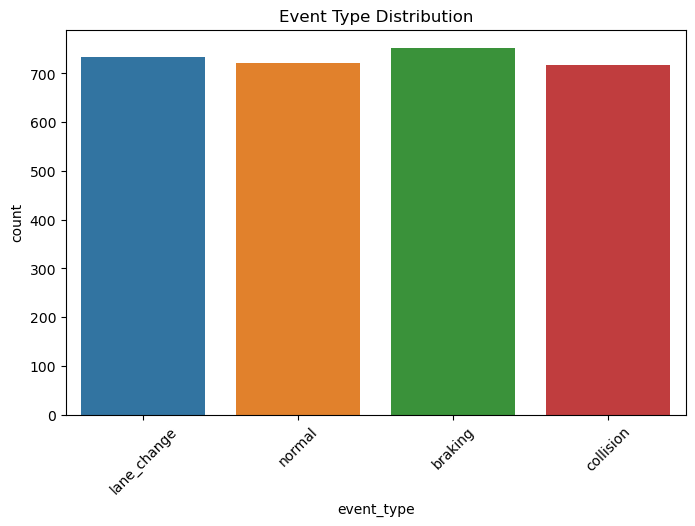

In [30]:
plt.figure(figsize=(8, 5))
sns.countplot(data=filtered_data_pandas, x='event_type')
plt.title('Event Type Distribution')
plt.xticks(rotation=45)
plt.show()

Speed Distribution (Histogram)
To visualize the distribution of vehicle speed

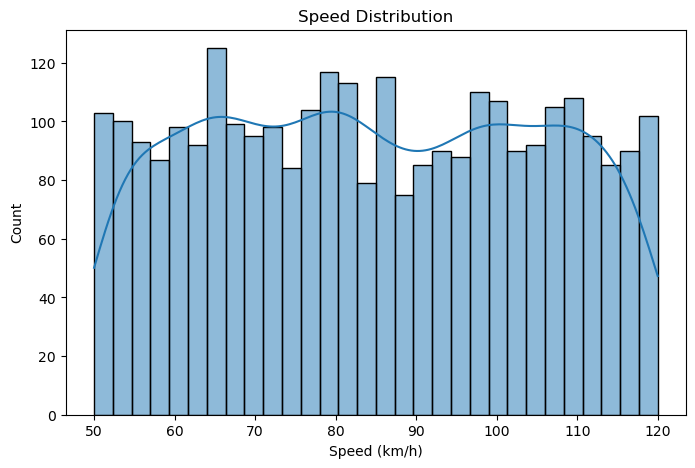

In [31]:
plt.figure(figsize=(8, 5))
sns.histplot(filtered_data_pandas['speed'], bins=30, kde=True)
plt.title('Speed Distribution')
plt.xlabel('Speed (km/h)')
plt.show()


Braking Events by Speed (Box Plot)
Compare the distribution of speeds during braking events.

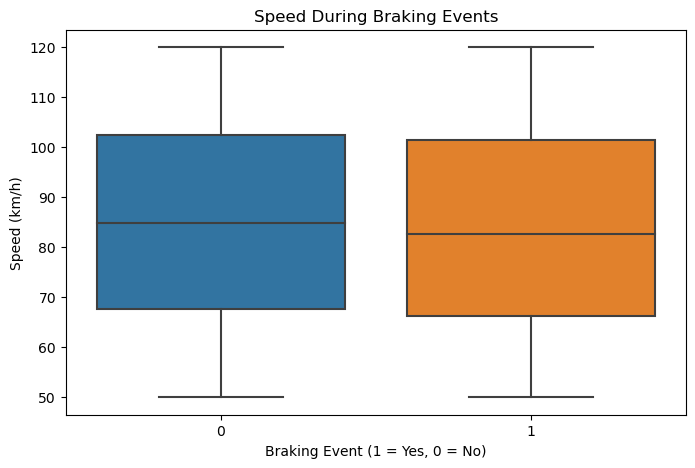

In [32]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='braking_event', y='speed', data=filtered_data_pandas)
plt.title('Speed During Braking Events')
plt.xlabel('Braking Event (1 = Yes, 0 = No)')
plt.ylabel('Speed (km/h)')
plt.show()


Vehicle Activity by Hour (Line Plot)
Analyze the number of events that occur during each hour of the day.

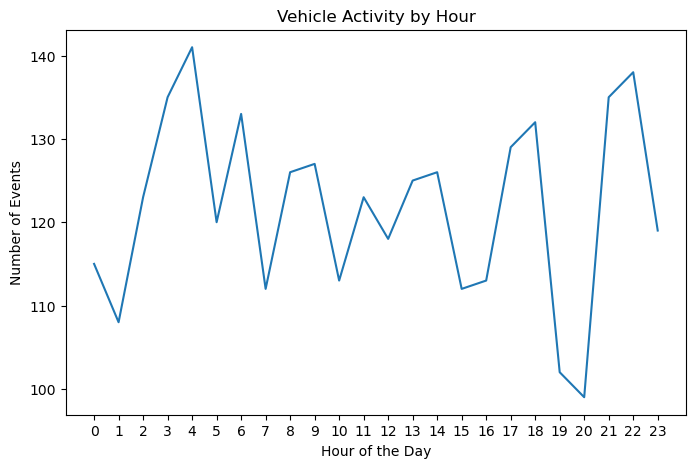

In [33]:
# First, create an hour column in the Pandas DataFrame
filtered_data_pandas['hour'] = filtered_data_pandas['timestamp'].dt.hour

# Group by hour to count events
hourly_events = filtered_data_pandas.groupby('hour').size().reset_index(name='count')

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=hourly_events, x='hour', y='count')
plt.title('Vehicle Activity by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.xticks(range(0, 24))
plt.show()


create a heatmap to visualize the correlation between different numerical columns.

/var/folders/2c/4xnzffps6fsdxfczqpbvrcyr0000gn/T/ipykernel_3064/3984993864.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = filtered_data_pandas.corr()


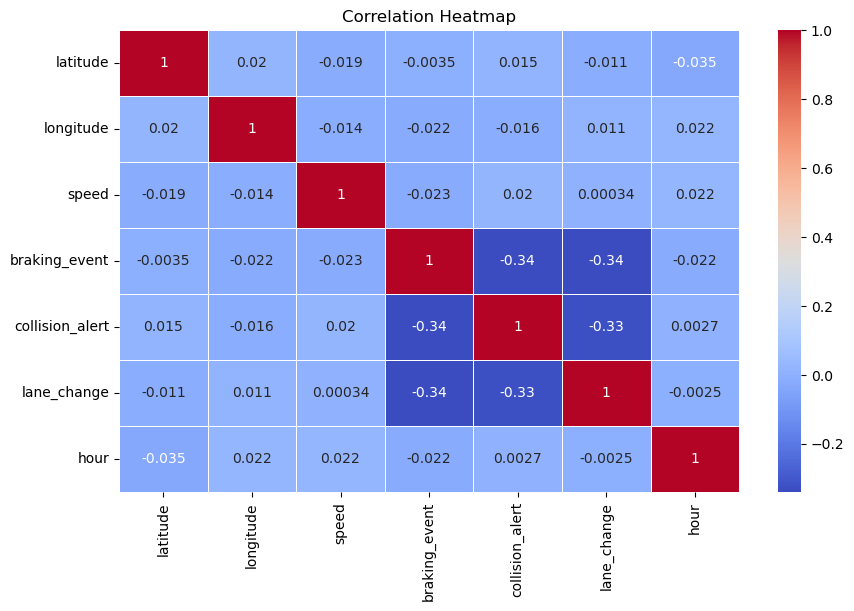

In [34]:
plt.figure(figsize=(10, 6))
correlation_matrix = filtered_data_pandas.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
